# 读取数据

In [1]:
import pickle
node_dict_amap={}
road_edges={}
orthogonal_list={}
road_zip={}
road_dict={}
with open('map_nodes_amap.pkl','rb') as f:
    node_dict_amap=pickle.load(f)
with open('road_edges.pkl','rb') as f:
    road_edges=pickle.load(f)
with open('graph.pkl','rb') as f:
    orthogonal_list=pickle.load(f)
with open('road_zip.pkl','rb') as f:
    road_zip=pickle.load(f)
with open('road_dict.pkl','rb') as f:
    road_dict=pickle.load(f)
road_dict={}
for no,road in enumerate(road_zip):
    road_dict[road]={'id':no}

# 相似度分析
## 时间相似度

In [2]:
import random
import math
import numpy as np
from progressbar import ProgressBar,Percentage,Bar,Timer,ETA,FileTransferSpeed
widgets = [
    'Progress: ',
    Percentage(), ' ',
    Bar('#'), ' ',
    Timer(), ' ',
    ETA(), ' ',
    FileTransferSpeed()
]

def fast_DTW(s1, s2, T=5):
    DTW={}
    for i in range(len(s1)):
        DTW[(i, -1)] = float('inf')
    for i in range(len(s2)):
        DTW[(-1, i)] = float('inf')
    DTW[(-1, -1)] = 0
    for i in range(len(s1)):
        for j in range(i-T-1,i+T+2):
            if j<0 or j>=len(s2):
                continue
            if math.fabs(i-j)<=T:
                dist= (s1[i]-s2[j])**2
                DTW[(i, j)] = dist + min(DTW[(i-1, j)],DTW[(i, j-1)],DTW[(i-1, j-1)])
            else:
                DTW[(i, j)]=float('inf')
    return math.sqrt(DTW[len(s1)-1, len(s2)-1])

def LB_Keogh(s1, s2, r=2):
    LB_sum = 0
    for ind, i in enumerate(s1):
         # print(s2)
        lower_bound = min(s2[(ind - r if ind - r >= 0 else 0):(ind + r)])
        upper_bound = max(s2[(ind - r if ind - r >= 0 else 0):(ind + r)])
        if i >= upper_bound:
            LB_sum = LB_sum + (i - upper_bound) ** 2
        elif i < lower_bound:
            LB_sum = LB_sum + (i - lower_bound) ** 2
    return math.sqrt(LB_sum)

def K_means(data,cluster_num,epoch,w=3):
    centroids={i:data[key] for i,key in enumerate(random.sample(list(data),cluster_num))}
    for n in range(epoch):
        clusters={}
        for key,value in data.items():
            min_dist=float('inf')
            closest_cluster=None
            for ckey,cvalue in centroids.items():
                cur_dist=fast_DTW(value,cvalue)
                if cur_dist<min_dist:
                    min_dist=cur_dist
                    closest_cluster=ckey
            if closest_cluster in clusters:
                clusters[closest_cluster].append(key)
            else:
                clusters[closest_cluster]=[key]
        for key,value in clusters.items():
            cluster_sum=0
            for item in value:
                cluster_sum+=data[item]
            centroids[key]=[m/len(clusters[key]) for m in cluster_sum]
    return centroids,clusters

data=np.array(list(road_zip.values()))[:,:,:,1]#road,date,time,regular_speed
data=data.swapaxes(0,1)#date,road,time,regular_speed
data=np.concatenate(data,axis=1)#road,datetime,regular_speed
assemble_matrix=[[0 for i in range(len(data))] for j in range(len(data))]
bar = ProgressBar(widgets=widgets, maxval=len(data)*len(data)).start()
for i in range(len(data)):
    for j in range(i,len(data)):
        assemble_matrix[i][j]=fast_DTW(data[i],data[j])
        bar.update(i*len(data)+j+1)
bar.finish()

#保存矩阵
import pickle
with open('assemble_matrix.pkl','wb') as f:
    pickle.dump(assemble_matrix, f)

IOPub message rate exceeded. | Elapsed Time: 12:34:18 ETA:  5:37:23  15.48  B/s
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



## 空间相似度

# 读取矩阵

In [2]:
import pickle
import numpy as np
assemble_matrix={}
with open('assemble_matrix.pkl','rb') as f:
    assemble_matrix=pickle.load(f)

for i in range(len(assemble_matrix)):
    for j in range(i,len(assemble_matrix[i])):
        assemble_matrix[j][i]=assemble_matrix[i][j]
assemble_matrix=np.array(assemble_matrix)
assemble_matrix=(assemble_matrix-assemble_matrix.min())/(assemble_matrix.max()-assemble_matrix.min())

# 绘制矩阵

In [7]:
#绘制矩阵
import cv2 as cv
sample=np.array(assemble_matrix)
sample=255.0*sample
cv.imwrite("assemble_matrix.png", sample)

True

# 聚类分析

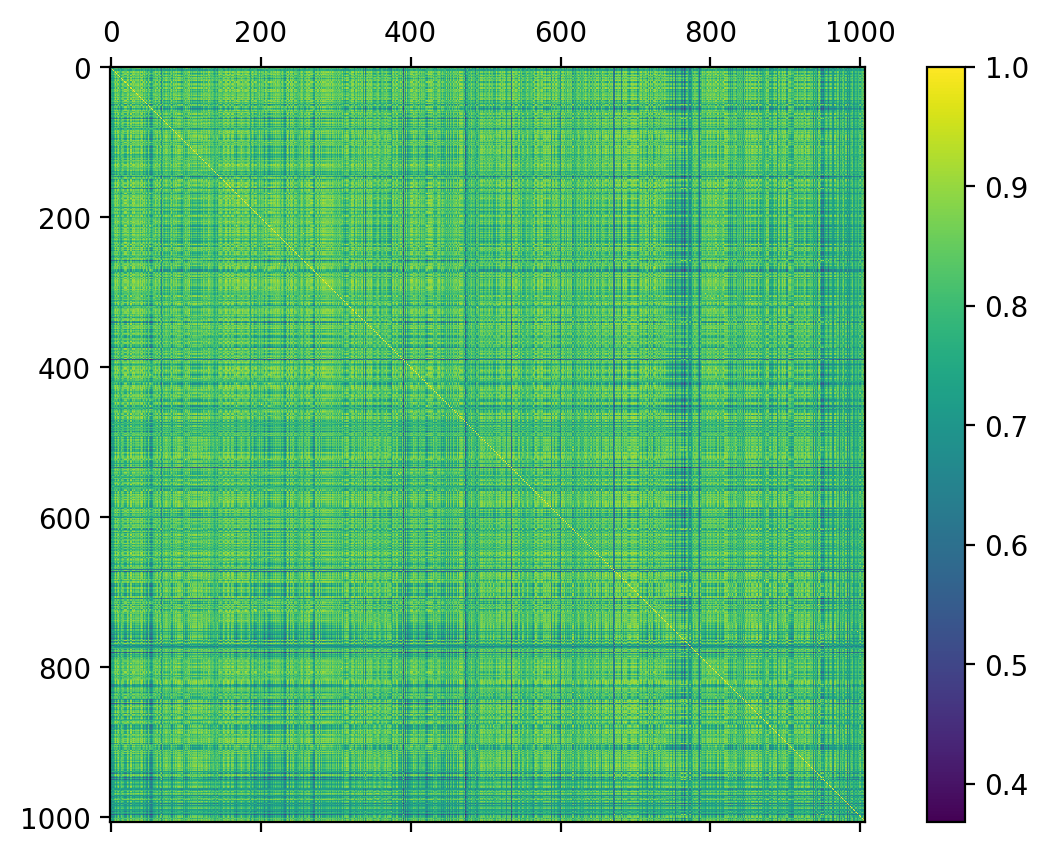

In [5]:
import math
affinity_matrix=[[0 for i in range(len(assemble_matrix))] for j in range(len(assemble_matrix))]
for i in range(len(assemble_matrix)):
    for j in range(i,len(assemble_matrix)):
        affinity_matrix[i][j]=math.exp(-assemble_matrix[i][j])
        affinity_matrix[j][i]=affinity_matrix[i][j]
# 绘制矩阵            
import matplotlib.pyplot as plt
from matplotlib import cm,colors
minium,maxium=min(np.array(affinity_matrix).flatten()),max(np.array(affinity_matrix).flatten())
fig,ax = plt.subplots(figsize=(8,5),dpi=200)
ax.matshow(affinity_matrix,cmap='viridis')
norm = colors.Normalize(vmin=minium, vmax=maxium)
im = cm.ScalarMappable(norm=norm, cmap='viridis')
fig.colorbar(im,ax=ax) 
fig.show()

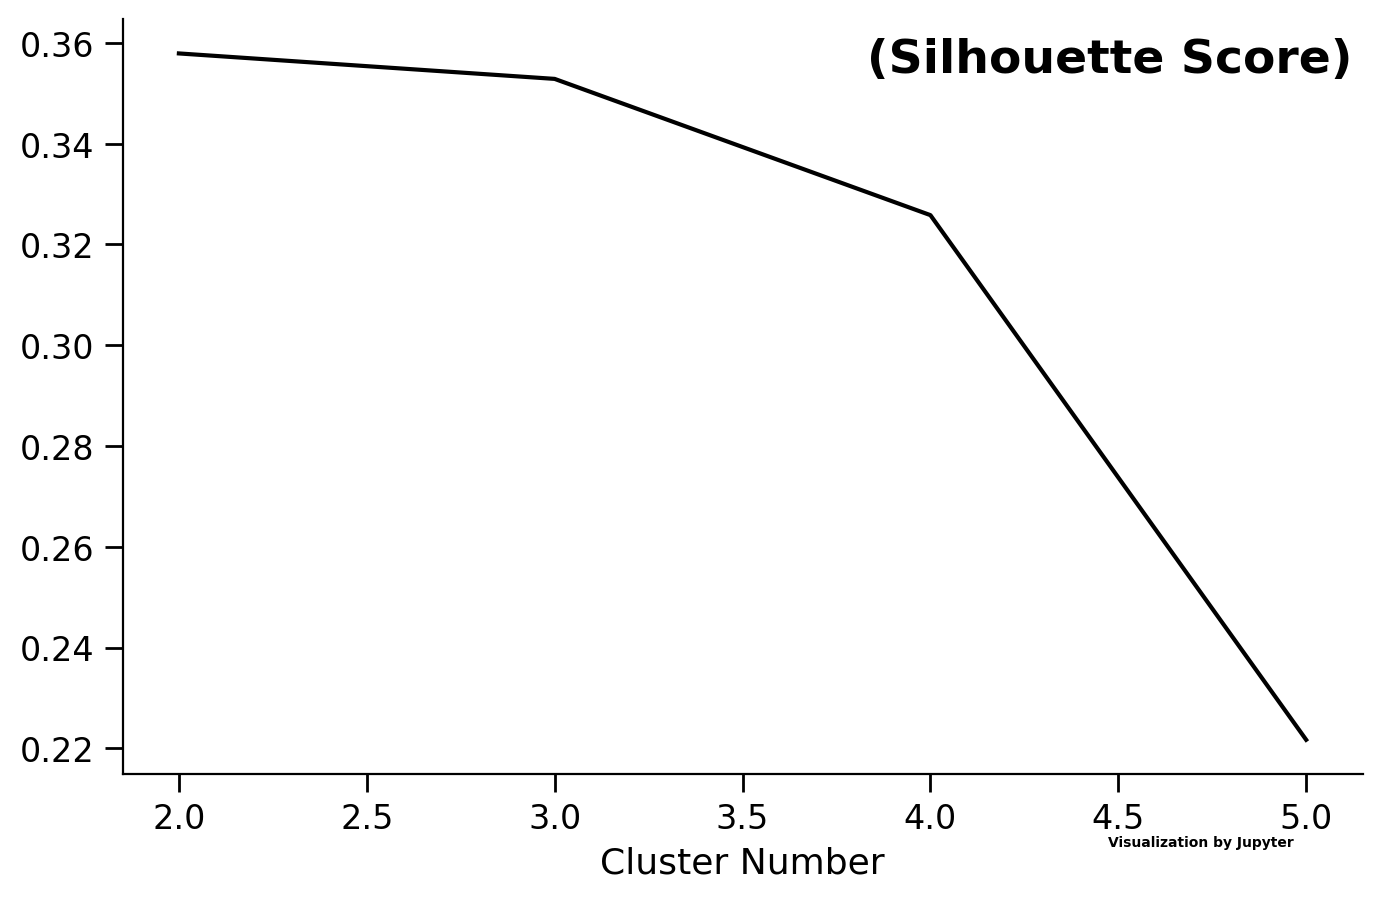

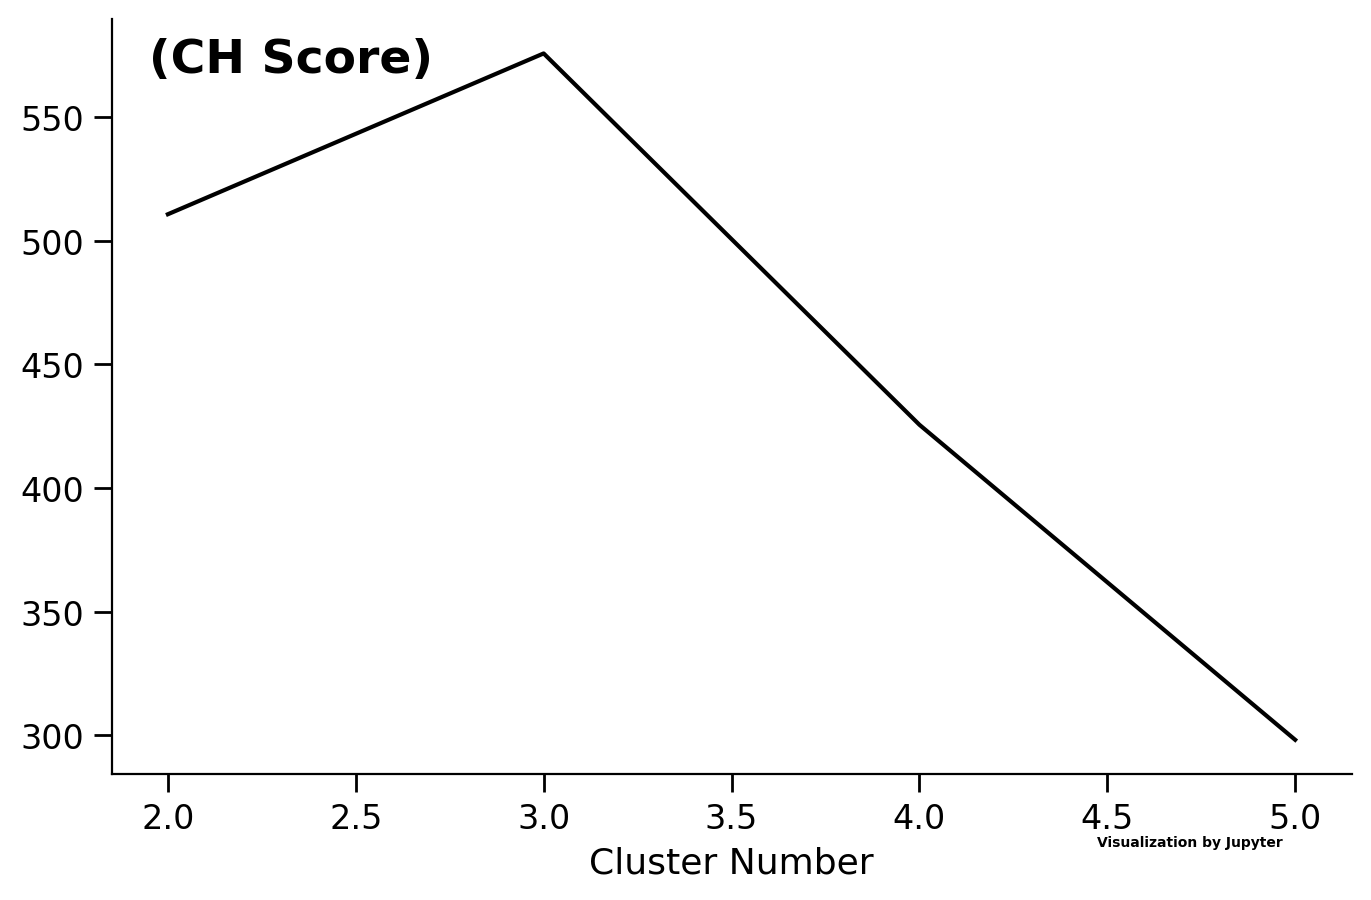

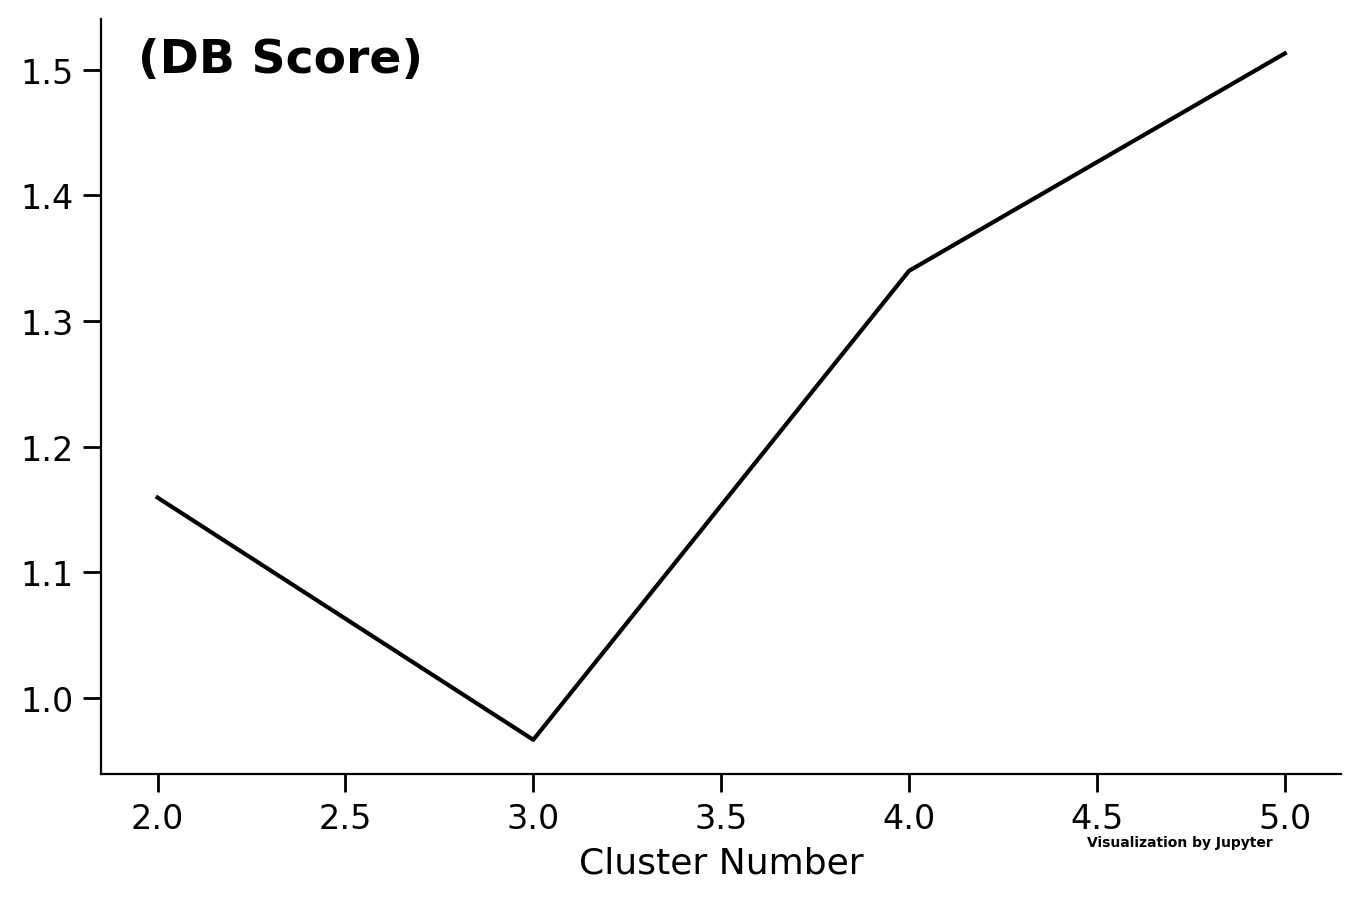

In [11]:
from sklearn.cluster import SpectralClustering
from sklearn import metrics
silhouette_score=[]
calinski_harabasz_score=[]
davies_bouldin_score=[]
for n_clusters in range(2,6):
    SC = SpectralClustering(n_clusters=n_clusters,
                            affinity='precomputed',
                            eigen_solver='arpack',
                            random_state=0,
                            assign_labels='kmeans')
    clustering = SC.fit(affinity_matrix)
    silhouette_score.append(metrics.silhouette_score(affinity_matrix,clustering.labels_,metric='euclidean'))
    calinski_harabasz_score.append(metrics.calinski_harabasz_score(affinity_matrix,clustering.labels_))
    davies_bouldin_score.append(metrics.davies_bouldin_score(affinity_matrix,clustering.labels_))

import matplotlib.pyplot as plt
fig,ax = plt.subplots(figsize=(8,5),dpi=200)
ax.plot(np.arange(2,6),silhouette_score,color='black')
ax.tick_params(direction='out',labelsize=12,length=6.5,width=1,top=False,right=False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('Cluster Number',fontsize=13)
text_font = {'size':'17','weight':'bold','color':'black'}
ax.text(.6,.93,'(Silhouette Score)',transform = ax.transAxes,fontdict=text_font,zorder=4)
ax.text(.87,-.08,'\nVisualization by Jupyter',transform = ax.transAxes, ha='center', va='center',fontsize = 5,color='black',fontweight='bold')
plt.show()

fig,ax = plt.subplots(figsize=(8,5),dpi=200)
ax.plot(np.arange(2,6),calinski_harabasz_score,color='black')
ax.tick_params(direction='out',labelsize=12,length=6.5,width=1,top=False,right=False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('Cluster Number',fontsize=13)
text_font = {'size':'17','weight':'bold','color':'black'}
ax.text(.03,.93,'(CH Score)',transform = ax.transAxes,fontdict=text_font,zorder=4)
ax.text(.87,-.08,'\nVisualization by Jupyter',transform = ax.transAxes, ha='center', va='center',fontsize = 5,color='black',fontweight='bold')
plt.show()

fig,ax = plt.subplots(figsize=(8,5),dpi=200)
ax.plot(np.arange(2,6),davies_bouldin_score,color='black')
ax.tick_params(direction='out',labelsize=12,length=6.5,width=1,top=False,right=False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('Cluster Number',fontsize=13)
text_font = {'size':'17','weight':'bold','color':'black'}
ax.text(.03,.93,'(DB Score)',transform = ax.transAxes,fontdict=text_font,zorder=4)
ax.text(.87,-.08,'\nVisualization by Jupyter',transform = ax.transAxes, ha='center', va='center',fontsize = 5,color='black',fontweight='bold')
plt.show()

In [6]:
from sklearn.cluster import SpectralClustering
n_clusters = 3
SC = SpectralClustering(n_clusters=n_clusters,
                        affinity='precomputed',
                        eigen_solver='arpack',
                        random_state=0,
                        assign_labels='kmeans')
clustering = SC.fit(affinity_matrix)
clusters=[[] for _ in range(n_clusters)]
for i,road in enumerate(road_zip.keys()):
    label=clustering.labels_[i]
    clusters[label].append(road)
for cluster in clusters:
    print(len(cluster))

310
516
181


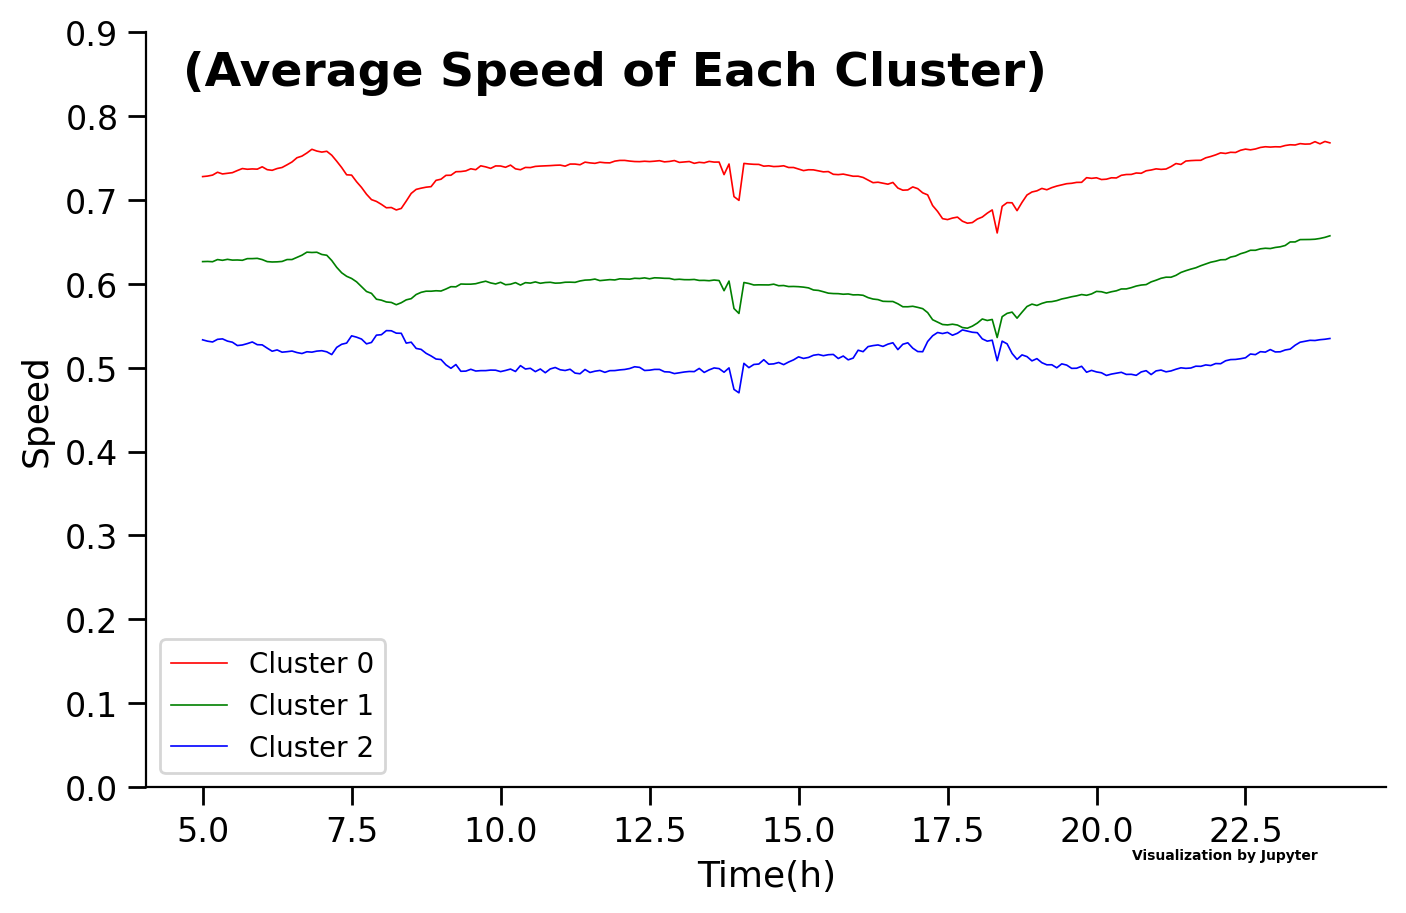

In [12]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(figsize=(8,5),dpi=200)
colors=['r','g','b']
curve={_:0 for _ in range(len(clusters))}
for no in range(len(clusters)):
    for road in clusters[no]:
        speed_seq=road_zip[road][:,:,1]
        speed_seq=np.mean(speed_seq,axis=0)
        curve[no]+=speed_seq
    curve[no]=curve[no]/len(clusters[no])
    label = [(i*5)/60+5 for i in range(len(curve[no]))]
    ax.plot(label, curve[no], color=colors[no], label=f'Cluster {no}', linewidth=.6)
ax.tick_params(direction='out',labelsize=12,length=6.5,width=1,top=False,right=False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel(f'Speed',fontsize=13)
ax.set_xlabel('Time(h)',fontsize=13)
ax.set_yticks([float(i)/10.0 for i in range(10)])
text_font = {'size':'17','weight':'bold','color':'black'}
ax.text(.03,.93,f'(Average Speed of Each Cluster)',transform = ax.transAxes,fontdict=text_font,zorder=4)
ax.text(.87,-.08,'\nVisualization by Jupyter',transform = ax.transAxes, ha='center', va='center',fontsize = 5,color='black',fontweight='bold')
ax.legend()
fig.show()

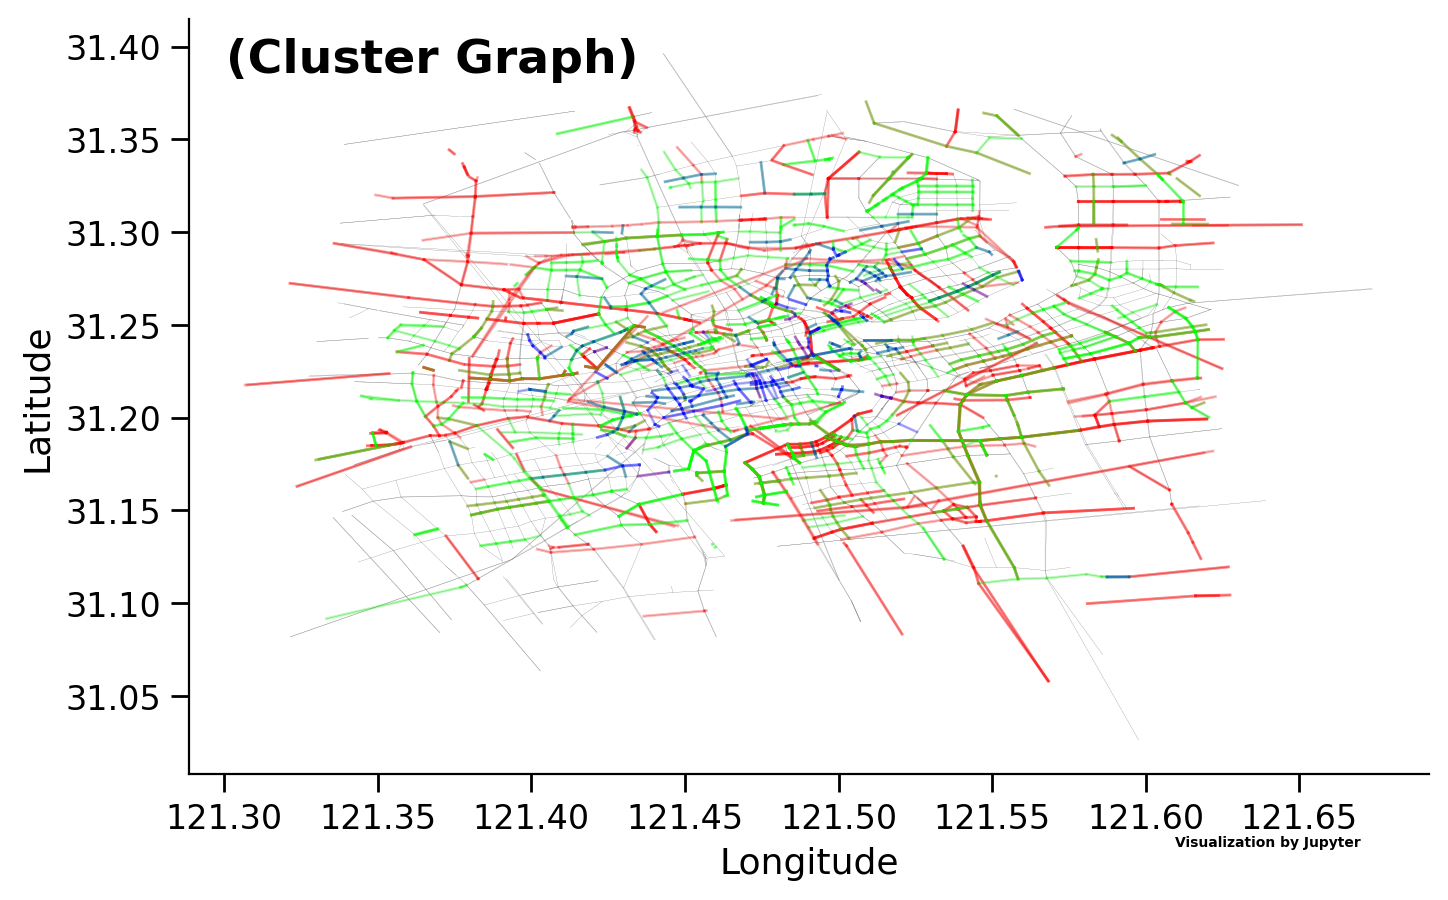

In [75]:
import matplotlib.pyplot as plt
# colors=['r','g','b','y','pink','brown','orange','black']
colors=[(1,0,0,0.3),(0,1,0,0.3),(0,0,1,0.3)]
fig,ax = plt.subplots(figsize=(8,5),dpi=200)
ref=node_dict_amap
for key,value in orthogonal_list.items():
    for e in value[1]:
        ax.plot([float(ref[key][0]),float(ref[e[1]][0])],[float(ref[key][1]),float(ref[e[1]][1])],color='grey',linewidth=.1)
        
for no in range(len(clusters)):
    for road in clusters[no]:
        if road not in road_edges:
            continue
        edges=road_edges[road]
        for edge in edges:
            a=edge[0]
            b=orthogonal_list[a][1][edge[1]][1]
            ax.plot([float(ref[a][0]),float(ref[b][0])],[float(ref[a][1]),float(ref[b][1])],color=colors[no],linewidth=1)

ax.tick_params(direction='out',labelsize=12,length=6.5,width=1,top=False,right=False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel('Latitude',fontsize=13)
ax.set_xlabel('Longitude',fontsize=13)
text_font = {'size':'17','weight':'bold','color':'black'}
ax.text(.03,.93,'(Cluster Graph)',transform = ax.transAxes,fontdict=text_font,zorder=4)
ax.text(.87,-.08,'\nVisualization by Jupyter',transform = ax.transAxes, ha='center', va='center',fontsize = 5,color='black',fontweight='bold')
fig.show()

In [37]:
#-*-coding:utf-8 -*-
"""
created by xingxinangrui on 2019.5.5
this is the simple demo that use sk-learn to run spectral clustering
"""
#demo one use iris dataset
import numpy as np
from sklearn import datasets
 
X = datasets.load_iris()
print(X)
# 查看默认的谱聚类效果
from sklearn.cluster import SpectralClustering
 
spectral = SpectralClustering()
pred_y = spectral.fit_predict(X.data)
from sklearn import metrics
 
print("Calinski-Harabasz Score", metrics.calinski_harabasz_score(X.data, pred_y))
"""
Calinski-Harabasz Score 438.286953256
"""
 
# 默认使用的是高斯核，需要对n_cluster和gamma进行调参，选择合适的参数
scores = []
s = dict()
for index, gamma in enumerate((0.01, 0.1, 1, 10)):
    for index, k in enumerate((3, 4, 5, 6)):
        pred_y = SpectralClustering(n_clusters=k).fit_predict(X.data)
        print("Calinski-Harabasz Score with gamma=", gamma, "n_cluster=", k, "score=",
              metrics.calinski_harabasz_score(X.data, pred_y))
        tmp = dict()
        tmp['gamma'] = gamma
        tmp['n_cluster'] = k
        tmp['score'] = metrics.calinski_harabasz_score(X.data, pred_y)
        s[metrics.calinski_harabasz_score(X.data, pred_y)] = tmp
        scores.append(metrics.calinski_harabasz_score(X.data, pred_y))
print(np.max(scores))
print("max score:")
print(s.get(np.max(scores)))

[[1.  1.  1.  0.2 0.  0.  0. ]
 [1.  1.  1.  0.2 0.  0.  0. ]
 [1.  1.  1.  0.2 0.  0.  0. ]
 [0.2 0.2 0.2 1.  1.  1.  1. ]
 [0.  0.  0.  1.  1.  1.  1. ]
 [0.  0.  0.  1.  1.  1.  1. ]
 [0.  0.  0.  1.  1.  1.  1. ]]
  (0, 0)	1.0
  (0, 1)	1.0
  (0, 2)	1.0
  (0, 3)	0.2
  (1, 0)	1.0
  (1, 1)	1.0
  (1, 2)	1.0
  (1, 3)	0.2
  (2, 0)	1.0
  (2, 1)	1.0
  (2, 2)	1.0
  (2, 3)	0.2
  (3, 0)	0.2
  (3, 1)	0.2
  (3, 2)	0.2
  (3, 3)	1.0
  (3, 4)	1.0
  (3, 5)	1.0
  (3, 6)	1.0
  (4, 3)	1.0
  (4, 4)	1.0
  (4, 5)	1.0
  (4, 6)	1.0
  (5, 3)	1.0
  (5, 4)	1.0
  (5, 5)	1.0
  (5, 6)	1.0
  (6, 3)	1.0
  (6, 4)	1.0
  (6, 5)	1.0
  (6, 6)	1.0


In [26]:
def myKNN(S, k, sigma=1.0):
    N = len(S)
    A = np.zeros((N,N))

    for i in range(N):
        dist_with_index = zip(S[i], range(N))
        dist_with_index = sorted(dist_with_index, key=lambda x:x[0])
        neighbours_id = [dist_with_index[m][1] for m in range(k+1)] # xi's k nearest neighbours

        for j in neighbours_id: # xj is xi's neighbour
            A[i][j] = np.exp(-S[i][j]/2/sigma/sigma)
            A[j][i] = A[i][j] # mutually

    return A
def calLaplacianMatrix(adjacentMatrix):

    # compute the Degree Matrix: D=sum(A)
    degreeMatrix = np.sum(adjacentMatrix, axis=1)

    # compute the Laplacian Matrix: L=D-A
    laplacianMatrix = np.diag(degreeMatrix) - adjacentMatrix

    # normailze
    # D^(-1/2) L D^(-1/2)
    sqrtDegreeMatrix = np.diag(1.0 / (degreeMatrix ** (0.5)))
    return np.dot(np.dot(sqrtDegreeMatrix, laplacianMatrix), sqrtDegreeMatrix)

In [20]:
A=myKNN(assemble_matrix)
print(A[0])

TypeError: myKNN() missing 1 required positional argument: 'k'

[[0.         2.         1.         2.        ]
 [1.         3.         8.18535277 3.        ]]


{'icoord': [[15.0, 15.0, 25.0, 25.0], [5.0, 5.0, 20.0, 20.0]],
 'dcoord': [[0.0, 1.0, 1.0, 0.0],
  [0.0, 8.18535277187245, 8.18535277187245, 1.0]],
 'ivl': ['b', 'a', 'c'],
 'leaves': [1, 0, 2],
 'color_list': ['g', 'b']}

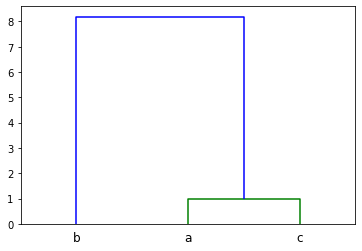

In [19]:
from scipy.cluster import hierarchy
import pandas as pd
df=pd.array([10,1,1])
Z=hierarchy.linkage(df, method='ward',metric='euclidean')
print(Z)
hierarchy.dendrogram(Z,labels=['a','b','c'])

{'data': array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2],
       [5.4, 3.9, 1.7, 0.4],
       [4.6, 3.4, 1.4, 0.3],
       [5. , 3.4, 1.5, 0.2],
       [4.4, 2.9, 1.4, 0.2],
       [4.9, 3.1, 1.5, 0.1],
       [5.4, 3.7, 1.5, 0.2],
       [4.8, 3.4, 1.6, 0.2],
       [4.8, 3. , 1.4, 0.1],
       [4.3, 3. , 1.1, 0.1],
       [5.8, 4. , 1.2, 0.2],
       [5.7, 4.4, 1.5, 0.4],
       [5.4, 3.9, 1.3, 0.4],
       [5.1, 3.5, 1.4, 0.3],
       [5.7, 3.8, 1.7, 0.3],
       [5.1, 3.8, 1.5, 0.3],
       [5.4, 3.4, 1.7, 0.2],
       [5.1, 3.7, 1.5, 0.4],
       [4.6, 3.6, 1. , 0.2],
       [5.1, 3.3, 1.7, 0.5],
       [4.8, 3.4, 1.9, 0.2],
       [5. , 3. , 1.6, 0.2],
       [5. , 3.4, 1.6, 0.4],
       [5.2, 3.5, 1.5, 0.2],
       [5.2, 3.4, 1.4, 0.2],
       [4.7, 3.2, 1.6, 0.2],
       [4.8, 3.1, 1.6, 0.2],
       [5.4, 3.4, 1.5, 0.4],
       [5.2, 4.1, 1.5, 0.1],
       [5.5, 4.2, 1.4, 0.2],
     